# Obtenção dos resultados no método semi-empírico.

###  1 - Obtenção do fit das medidas experimentais para o coeficiente Seebeck. Extraído de Brunst and Weiser.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


plt.style.use('seaborn-darkgrid')

In [2]:
df_exp1 = pd.read_table("1_seebeck_e_potquim/1_experimental/seebeck_bolas", names=["1/T", "Seebeck"])
df_exp2 = pd.read_table("1_seebeck_e_potquim/1_experimental/seebeck_cruzes", names=["1/T", "Seebeck"])

In [3]:
df_exp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   1/T      11 non-null     float64
 1   Seebeck  11 non-null     float64
dtypes: float64(2)
memory usage: 304.0 bytes


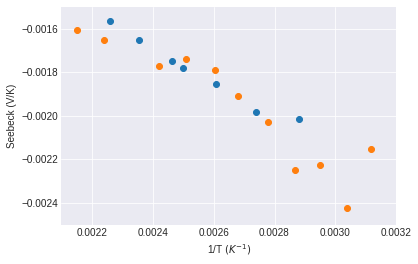

In [4]:
plt.scatter( df_exp1["1/T"].to_numpy(), df_exp1["Seebeck"].to_numpy())
plt.scatter( df_exp2["1/T"].to_numpy(), df_exp2["Seebeck"].to_numpy())

plt.xlim(0.0021, 0.0032)
plt.ylim(-0.0025, -0.0015)
plt.xlabel("1/T $(K^{-1})$")
plt.ylabel("Seebeck (V/K)")


plt.show()

In [5]:
X = np.concatenate((df_exp1["1/T"].to_numpy(), df_exp2["1/T"].to_numpy())).reshape(-1, 1)
y = np.concatenate((df_exp1["Seebeck"].to_numpy(), df_exp2["Seebeck"].to_numpy())).reshape(-1,1)

In [6]:
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)


print(f"Coeficiente angular: {reg.coef_[0][0]}")
print(f"Coeficiente linear: {reg.intercept_[0]}\n")
print(f"R2 = {r2_score(y, y_pred)}")

Coeficiente angular: -0.8123293921455202
Coeficiente linear: 0.00023097897104548204

R2 = 0.876714733884635


In [7]:
y_pred = reg.predict(X)

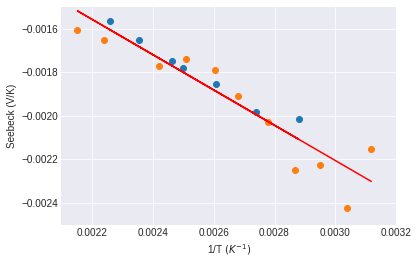

In [8]:
plt.scatter( df_exp1["1/T"].to_numpy(), df_exp1["Seebeck"].to_numpy())
plt.scatter( df_exp2["1/T"].to_numpy(), df_exp2["Seebeck"].to_numpy())

plt.xlim(0.0021, 0.0032)
plt.ylim(-0.0025, -0.0015)
plt.xlabel("1/T $(K^{-1})$")
plt.ylabel("Seebeck (V/K)")
plt.plot(X, y_pred, c="r")

plt.show()

Salvamos o fit em função da temperatura, por simplicidade, expandindo o range de temperaturas.

In [9]:
escrita = open("./1_seebeck_e_potquim/1_experimental/fit_seebeck", "w")
for T in range(260, 601, 1):
    escrita.write(f"{T}\t{reg.predict(np.array(1/T).reshape(-1,1))[0][0]}\n")
escrita.close()

### 1.1 - Extraindo o potencial químico dos dados calculados.

Pegamos os dados do seebeck gerado (que é experimental) e buscamos no .condtens o potquim que gera o seebeck calculado mais próximo do fitado para cada temperatura.

Nesse caso, já vou pegar o arquivo .condtens resumido gerado no tratamento de dados feito no notebook onde calculamos Z(mu, tau, T). Afinal, lá, os dados do potquim já estão em unidades de eV e o arquivo é muito menor!

In [10]:
def carrega_dados(arquivo_experimental, arquivo_calculado, coluna_calc):
    #coluna_calc é a posição da coluna
    #onde está o seebeck na direção de interesse

    print("carregando dados...")
    EXPERIMENTAL = open(arquivo_experimental, 'r')
    CALCULADO = open(arquivo_calculado, 'r')
    experimental, calculado = [], []
    
    for linhaexp in EXPERIMENTAL:
        linhaexp = linhaexp.strip().split()
        experimental.append([float(i) for i in linhaexp])
    
    for linhacalc in CALCULADO:
        linhacalc = linhacalc.strip().split()
        prov = linhacalc[0:2]+[linhacalc[coluna_calc]]
        calculado.append([float(i) for i in prov])
    
    return experimental, calculado


def minera_potencial(experimental, calculado):
    print("Buscando potenciais ótimos...")
    ESCRITA = open('./1_seebeck_e_potquim/2_mu_vs_T/potquim_func_Temp', 'w')
    
    for exp in experimental:
        dS_min = 10
        for calc in calculado:
            if round(exp[0],0) == round(calc[1],0):
                dS = (calc[2] - exp[1]) ** 2
                if dS < dS_min:
                    dS_min = dS
                    Ef = calc[0]
                    T = calc[1]
        ESCRITA.write(f'{T}\t{Ef}\n')
    ESCRITA.close()
    return 0 





arquivo_experimental = './1_seebeck_e_potquim/1_experimental/fit_seebeck'
arquivo_calculado = './condtens_resumido_kappa_corrigido'

dados_exp, dados_calc = carrega_dados(arquivo_experimental, arquivo_calculado, 5)
minera_potencial(dados_exp, dados_calc)

print("Concluido!")

carregando dados...
Buscando potenciais ótimos...
Concluido!


Plotando os dados juntamente com os valores experimentais de potquim. Isso é feito como uma maneira de validar os dados dos calculos anteriores.

maior desvio foi de 0.01208 eV. Isso representa um desvio de 0.85 por cento do experimental, na temperatura de 600.




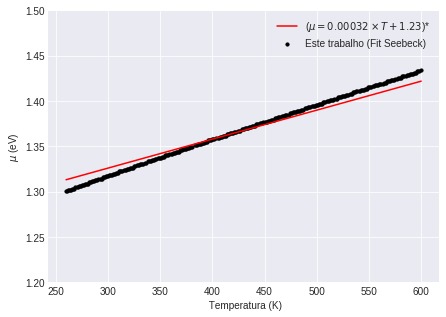

In [11]:
dados = open('1_seebeck_e_potquim/2_mu_vs_T/potquim_func_Temp', 'r')
mu = []
T = []
brunst = []


while True:
    line = [float(j) for j in dados.readline().strip().split()]
    T.append(line[0])
    mu.append(line[1])
    if line[0] ==600:
        break

for i in range(260, 601):
    prov = 1.23 + 0.00032 * i
    brunst.append(prov)

delta_maior = 0
temperatura = 260
for calc in mu:
    delta = calc - (1.23 + 0.00032 * temperatura)
    if delta > delta_maior and delta > 0:
        delta_maior = delta
        Temp_maior = temperatura
        porcentagem = (delta / (1.23 + 0.00032 * temperatura)) * 100
    temperatura += 1
print(f'maior desvio foi de {round(delta_maior, 7)} eV. Isso representa um desvio de {round(porcentagem, 3)} por cento do experimental, na temperatura de {Temp_maior}.\n\n')


fig = plt.figure(figsize=(7,5))

plt.scatter(T, mu, s=10, color='black', label=r'Este trabalho (Fit Seebeck)')
plt.plot(T, brunst, 'r', label=r'($\mu = 0.00032\times T + 1.23$)*')

plt.legend(loc='best')
plt.xlabel(r' Temperatura (K)')
plt.ylabel(r'$\mu$ (eV)')
plt.ylim(1.2, 1.5)
plt.show()
#plt.savefig('potquim_as2se3.png')


Há uma pequena diferença desse com relação ao gráfico que aparece na dissertação. Isso pois os dados não são exatamente o mesmo. Esses resultado foram feitos com um cálculo mais bem convergido, usando grids mais densos. São os que usaremos no artigo.

Finalmente, agora que conhecemos $\mu(T)$ podemos obter o coeficiente Seebeck em função da temperatura:

In [12]:
def carrega_dados2(calculado, potquim, col1, col2, col3):
    print("carregando dados...")
    CALCULADO = open(calculado, 'r')
    POTQUIM = open(potquim, 'r')
    calc, potquim = [], []
    
    for line_pot in POTQUIM:
        line_pot = [float(i) for i in line_pot.strip().split()]
        potquim.append(line_pot)
        
    for line_boltz in CALCULADO:
        line_boltz = [float (i) for i in line_boltz.strip().split()]
        prov = [line_boltz[0], line_boltz[1], line_boltz[col1], line_boltz[col2], line_boltz[col3]]
        calc.append(prov)
        
    CALCULADO.close()
    POTQUIM.close()
        
    return calc, potquim

In [13]:
condtens = './condtens_resumido_kappa_corrigido'
path_potquim = './1_seebeck_e_potquim/2_mu_vs_T/potquim_func_Temp'
calc, potquim = carrega_dados2(condtens, path_potquim, 5, 6, 7)

print("Extraindo")
seebeck = open('./1_seebeck_e_potquim/5_extract_seebeck/seebeck_mu_func_Temp', 'w')
for inst_pot in potquim:
    for inst_calc in calc:
        if inst_calc[0] == inst_pot[1] and inst_calc[1] == inst_pot[0]:
                seebeck.write(f'{inst_calc[0]}\t{inst_calc[1]}\t{inst_calc[2]}\t{inst_calc[3]}\t{inst_calc[4]}\n')
                break
seebeck.close()

carregando dados...
Extraindo


In [14]:
data = []
seebeck = open('./1_seebeck_e_potquim/5_extract_seebeck/seebeck_mu_func_Temp', 'r')
for line in seebeck:
    line = [float(i) for i in line.strip().split()]
    if line[0] > 1.1: #Isso elimina um ruído que aparece no potencial químico.
        data.append(line)
seebeck.close()
data = np.array(data)

In [15]:
data.shape

(327, 5)

In [16]:
data

array([[ 1.3007500e+00,  2.6000000e+02, -2.8925561e-03, -2.8762790e-03,
        -2.9121386e-03],
       [ 1.3007500e+00,  2.6100000e+02, -2.8823042e-03, -2.8660212e-03,
        -2.9019891e-03],
       [ 1.3021100e+00,  2.6200000e+02, -2.8669680e-03, -2.8506769e-03,
        -2.8867759e-03],
       ...,
       [ 1.4327200e+00,  5.9700000e+02, -1.1292326e-03, -1.1226736e-03,
        -1.1563491e-03],
       [ 1.4327200e+00,  5.9800000e+02, -1.1275821e-03, -1.1210454e-03,
        -1.1547076e-03],
       [ 1.4340800e+00,  6.0000000e+02, -1.1220297e-03, -1.1155375e-03,
        -1.1491731e-03]])

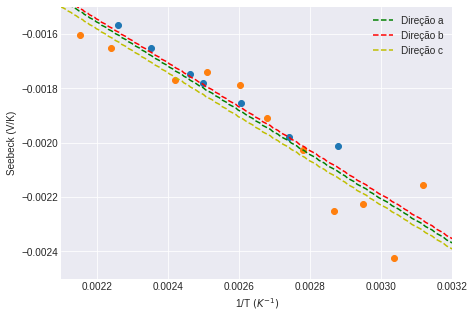

In [17]:
plt.figure(figsize = (7,5))

plt.scatter( df_exp1["1/T"].to_numpy(), df_exp1["Seebeck"].to_numpy())
plt.scatter( df_exp2["1/T"].to_numpy(), df_exp2["Seebeck"].to_numpy())

plt.plot(1/data[:,1], data[:,2], "--g", label="Direção a")
plt.plot(1/data[:,1], data[:,3], "--r", label="Direção b")
plt.plot(1/data[:,1], data[:,4], "--y", label="Direção c")

plt.legend()
plt.xlim(0.0021, 0.0032)
plt.ylim(-0.0025, -0.0015)
plt.xlabel("1/T $(K^{-1})$")
plt.ylabel("Seebeck (V/K)")


plt.show()

## 2 - Obtendo os tempos de relaxaçãopor meio do ajuste da condutividade elétrica

In [18]:
par_inf = np.loadtxt("2_condutividade/1_experimental/artigo/1_extraidos/paralelo_inferior")
par_sup = np.loadtxt("2_condutividade/1_experimental/artigo/1_extraidos/paralelo_superior")
perp_inf = np.loadtxt("2_condutividade/1_experimental/artigo/1_extraidos/perpendicular_inferior")
perp_sup = np.loadtxt("2_condutividade/1_experimental/artigo/1_extraidos/perpendicular_superior")

In [19]:
par_inf[:,0]

array([0.00217828, 0.00240255, 0.0025968 , 0.00280437, 0.00300075,
       0.00320273, 0.00339805, 0.00360673])

[]

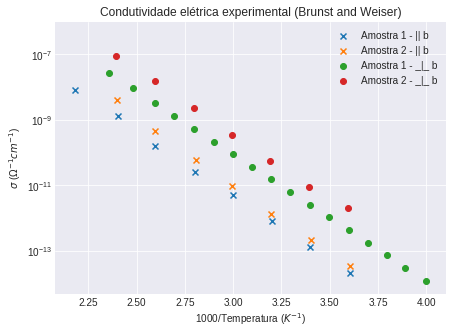

In [20]:
plt.figure(figsize = (7,5))

plt.scatter(par_inf[:,0]*1000, par_inf[:,1], label="Amostra 1 - || b", marker="x")
plt.scatter(par_sup[:,0]*1000, par_sup[:,1], label="Amostra 2 - || b", marker="x")
plt.scatter(perp_inf[:,0]*1000, perp_inf[:,1], label="Amostra 1 - _|_ b")
plt.scatter(perp_sup[:,0]*1000, perp_sup[:,1], label="Amostra 2 - _|_ b")

plt.ylim(5E-15, 1E-6)
plt.yscale("log")

plt.legend()
plt.title("Condutividade elétrica experimental (Brunst and Weiser)")
plt.xlabel("1000/Temperatura ($K^{-1}$)")
plt.ylabel("$\sigma$ ($\Omega^{-1}cm^{-1}$)")

plt.plot()

Medida		Coeficiente angular	Coficiente Linear	R2

['Amostra 1 - || b', -9026.266424773534, 1.0375205349625922, 0.9994903618483569]
['Amostra 2 - || b', -9663.456862007322, 3.671003965704653, 0.9991793207933648]
['Amostra 1 - _|_ b', -8925.920651179622, 3.622966366703011, 0.9999444465072723]
['Amostra 2 - _|_ b', -9077.813956063335, 5.4826480657989975, 0.9989470980689148]


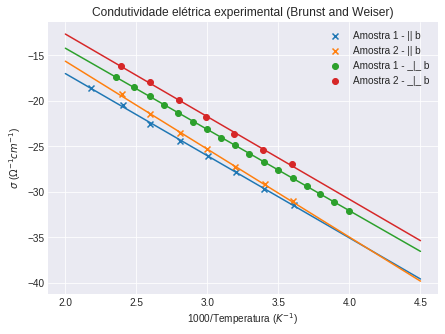

In [21]:
def fit_exp_and_plot(conjunto_de_medidas, legenda = None, marcador = None):
    
    X = conjunto_de_medidas[:,0].reshape(-1,1)
    y = conjunto_de_medidas[:,1].reshape(-1,1)
    y = np.log(y)
    
    reg = LinearRegression().fit(X,y)
    y_pred = reg.predict(X)
    
    x = np.array([0.002, 0.0045]).reshape(-1,1)
    y_ajuste = reg.predict(x)
    
    plt.scatter(X*1000,y, label=legenda, marker=marcador)
    plt.plot(x*1000, y_ajuste)
    
    
    return [legenda, reg.coef_[0][0], reg.intercept_[0], r2_score(y, y_pred)]

    
plt.figure(figsize = (7,5))    

print("Medida\t\tCoeficiente angular\tCoficiente Linear\tR2\n")
print(fit_exp_and_plot(par_inf, "Amostra 1 - || b", "x"))
print(fit_exp_and_plot(par_sup, "Amostra 2 - || b", "x"))
print(fit_exp_and_plot(perp_inf, "Amostra 1 - _|_ b"))
print(fit_exp_and_plot(perp_sup, "Amostra 2 - _|_ b"))


plt.legend()
plt.title("Condutividade elétrica experimental (Brunst and Weiser)")
plt.xlabel("1000/Temperatura ($K^{-1}$)")
plt.ylabel("$\sigma$ ($\Omega^{-1}cm^{-1}$)")

plt.show()    
    

Assim como feito para o coeficiente Seebeck, vamos extrair $\sigma(\mu(T))$

In [22]:
condtens = './condtens_resumido_kappa_corrigido'
path_potquim = './1_seebeck_e_potquim/2_mu_vs_T/potquim_func_Temp'

calc, potquim = carrega_dados2(condtens, path_potquim, 2, 3, 4)

print("Extraindo...")
sigma = open('./2_condutividade/2_calculado/sigma_func_Temp', 'w')
for inst_pot in potquim:
    for inst_calc in calc:
        if inst_calc[0] == inst_pot[1] and inst_calc[1] == inst_pot[0]:
                sigma.write(f'{inst_calc[0]}\t{inst_calc[1]}\t{inst_calc[2]}\t{inst_calc[3]}\t{inst_calc[4]}\n')
                break
seebeck.close()
print("Concluído!!")

carregando dados...
Extraindo...
Concluído!!


In [23]:
data = []
sigma = open('./2_condutividade/2_calculado/sigma_func_Temp', 'r')
for line in sigma:
    line = [float(i) for i in line.strip().split()]
    if line[0] > 1.1: #Isso elimina um ruído que aparece no potencial químico.
        data.append(line)
sigma.close()
data = np.array(data)

Text(0, 0.5, '$\\sigma$')

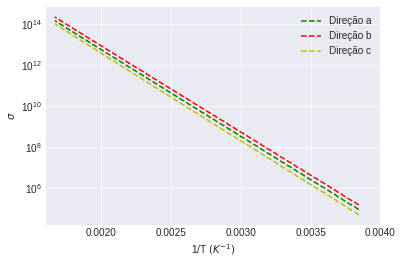

In [24]:
plt.plot(1/data[:,1], data[:,2], "--g", label="Direção a")
plt.plot(1/data[:,1], data[:,3], "--r", label="Direção b")
plt.plot(1/data[:,1], data[:,4], "--y", label="Direção c")

plt.legend()
plt.xlim(0.0016, 0.004)
plt.yscale("log")
plt.xlabel("1/T $(K^{-1})$")
plt.ylabel("$\sigma$")

Agora, para obter os tempos de relaxação basta dividirmos a condutividade elétrica experimental pela calculada no boltztrap, e para obter a condutividade térmica, basta multiplicar esses tempos de relaxação obtidos pelos calculados com o BoltzTraP. 

Esse processo é similar aos vários já realizados aqui. 